# Linear Regression — California Housing Dataset
Following the 14-step framework (dataset → preprocessing → EDA → regression → diagnostics → tuning → summary)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro

## Step 1: Dataset

In [2]:
housing = fetch_california_housing(as_frame=True)
df = housing.frame.copy()

print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
print("Target:", housing.target_names)

Rows: 20640
Columns: 9
Target: ['MedHouseVal']


## Step 2: Preprocessing

In [3]:
# Standardize column names
df.columns = [c.lower() for c in df.columns]

# Duplicates
print("Duplicates:", df.duplicated().sum())

# Missing values
print("Missing values:\n", df.isnull().sum())

# No categorical features → skipping encoding
# Scaling needed
scaler = StandardScaler()

X = df.drop("medhouseval", axis=1)
y = df["medhouseval"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Duplicates: 0
Missing values:
 medinc         0
houseage       0
averooms       0
avebedrms      0
population     0
aveoccup       0
latitude       0
longitude      0
medhouseval    0
dtype: int64


## Step 3: Feature Inventory

In [4]:
feature_inventory = pd.DataFrame({
    "Feature": X.columns,
    "Type": ["Numeric"] * X.shape[1],
    "Missing%": (X.isnull().sum() / len(X)) * 100,
    "Include?": ["Y"] * X.shape[1],
    "Notes": ["Kept" for _ in X.columns]
})
feature_inventory

,Feature,Type,Missing%,Include?,Notes
medinc,medinc,Numeric,0.0,Y,Kept
houseage,houseage,Numeric,0.0,Y,Kept
averooms,averooms,Numeric,0.0,Y,Kept
avebedrms,avebedrms,Numeric,0.0,Y,Kept
population,population,Numeric,0.0,Y,Kept
aveoccup,aveoccup,Numeric,0.0,Y,Kept
latitude,latitude,Numeric,0.0,Y,Kept
longitude,longitude,Numeric,0.0,Y,Kept


## Step 4: EDA — Univariate

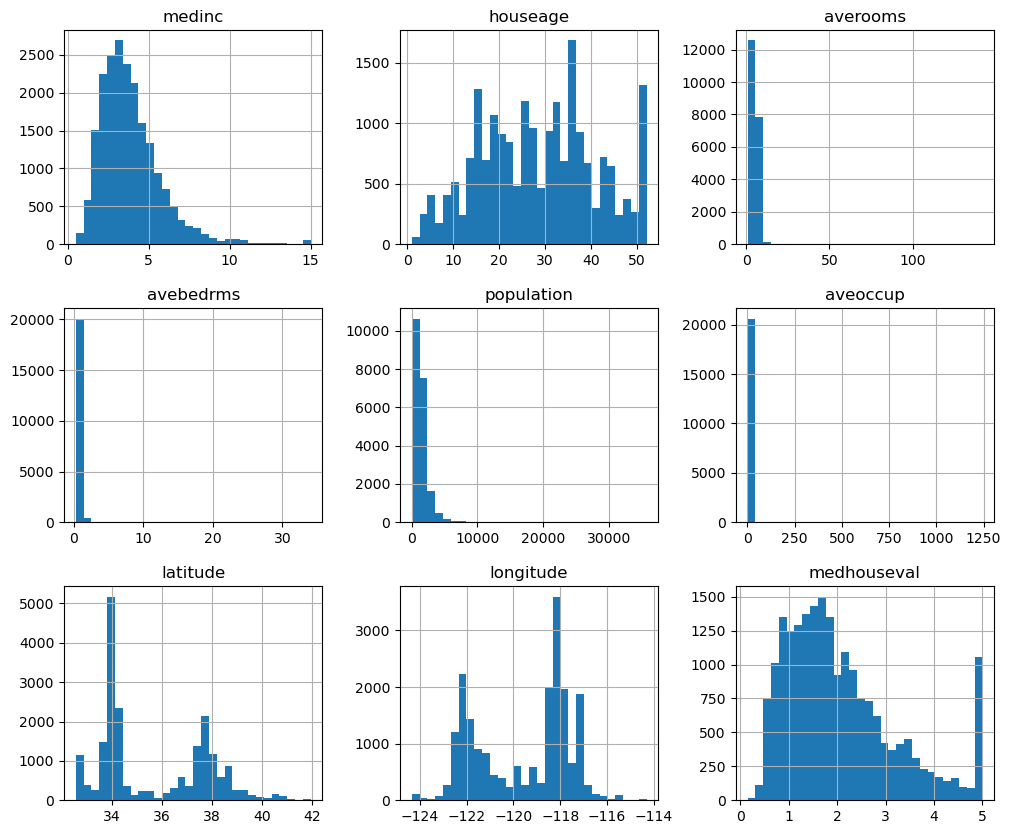

medinc          1.646657
houseage        0.060331
averooms       20.697869
avebedrms      31.316956
population      4.935858
aveoccup       97.639561
latitude        0.465953
longitude      -0.297801
medhouseval     0.977763
dtype: float64

In [5]:
df.hist(figsize=(12, 10), bins=30)
plt.show()

# Skewness
df.skew()

## Step 5: EDA — Multivariate

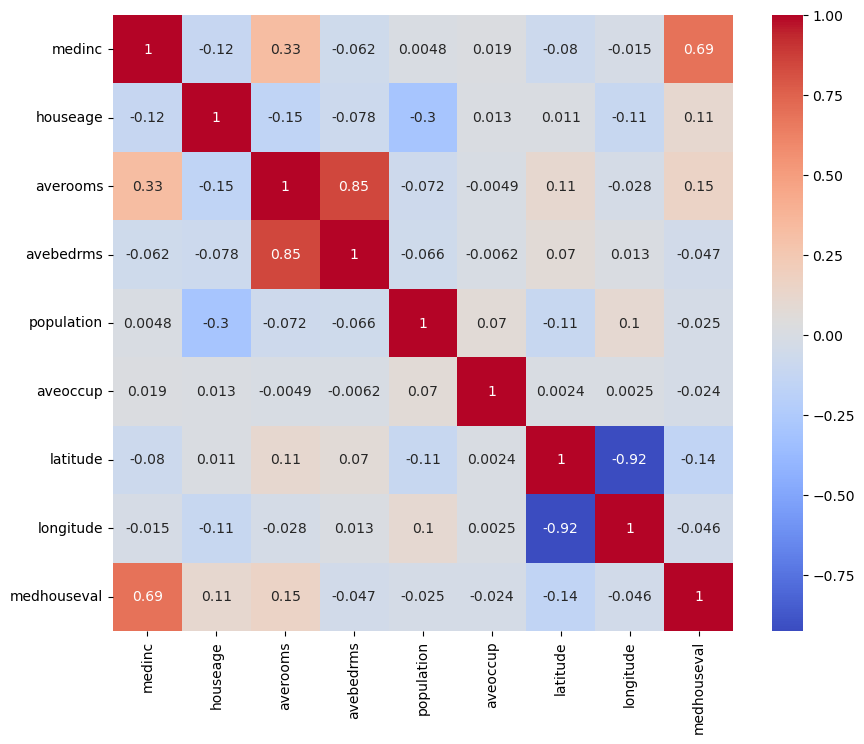

medhouseval    1.000000
medinc         0.688075
averooms       0.151948
houseage       0.105623
aveoccup      -0.023737
population    -0.024650
longitude     -0.045967
avebedrms     -0.046701
latitude      -0.144160
Name: medhouseval, dtype: float64

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()

df.corr()["medhouseval"].sort_values(ascending=False)

## Step 6: Regression Setup

In [7]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

## Step 7: Metrics

In [8]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_test = r2_score(y_test, y_pred)
r2_train = lr.score(X_train_scaled, y_train)
gap = r2_train - r2_test

print(f"MAE={mae:.3f}, MSE={mse:.3f}, RMSE={rmse:.3f}")
print(f"R² Test={r2_test:.3f}, R² Train={r2_train:.3f}, Gap={gap:.3f}")

MAE=0.533, MSE=0.556, RMSE=0.746
R² Test=0.576, R² Train=0.613, Gap=0.037


## Step 8: Interpretability (Coefficients)

In [9]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr.coef_
}).sort_values("Coefficient", key=abs, ascending=False)

coef_df

,Feature,Coefficient
6,latitude,-0.896929
7,longitude,-0.869842
0,medinc,0.854383
3,avebedrms,0.339259
2,averooms,-0.294410
1,houseage,0.122546
5,aveoccup,-0.040829
4,population,-0.002308


## Step 9: Multicollinearity & Assumptions

In [10]:
# VIF
vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train_scaled.shape[1])]

# Residuals
residuals = y_test - y_pred

# Shapiro
sh_stat, sh_p = shapiro(residuals)

# Durbin–Watson
dw = durbin_watson(residuals)

# Breusch–Pagan
X_bp = sm.add_constant(X_test_scaled)
bp_stat, bp_p, _, _ = het_breuschpagan(residuals, X_bp)

print(f"Shapiro p={sh_p:.3f} | Durbin–Watson={dw:.2f} | Breusch–Pagan p={bp_p:.3f}")
vif_df

Shapiro p=0.000 | Durbin–Watson=2.04 | Breusch–Pagan p=0.000


,Feature,VIF
0,medinc,2.539815
1,houseage,1.237337
2,averooms,7.917240
3,avebedrms,6.609200
4,population,1.134824
5,aveoccup,1.009733
6,latitude,9.206134
7,longitude,8.875984


## Step 10: Tuning F1 — Polynomial Features

In [11]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_train_scaled[:, [2]])
X_poly_test = poly.transform(X_test_scaled[:, [2]])

lr_poly = LinearRegression()
lr_poly.fit(X_poly, y_train)
r2_poly = lr_poly.score(X_poly_test, y_test)
print("Polynomial Feature (degree=2) R²:", r2_poly)

Polynomial Feature (degree=2) R²: 0.046212417545575146


## Step 11: Tuning F2 — Encoding Impact

In [12]:
# No categoricals in dataset → mark as N/A
print("Encoding impact: N/A (all numeric features)")

Encoding impact: N/A (all numeric features)


## Step 12: Tuning F3 — Regularization

In [13]:
for model, name, alphas in [(Ridge, "Ridge", [0.1, 1, 10]), (Lasso, "Lasso", [0.01, 0.1, 1])]:
    for alpha in alphas:
        reg = model(alpha=alpha)
        reg.fit(X_train_scaled, y_train)
        r2_cv = np.mean(cross_val_score(reg, X_train_scaled, y_train, cv=5, scoring="r2"))
        print(f"{name} α={alpha}: CV R²={r2_cv:.3f}")

Ridge α=0.1: CV R²=0.611
Ridge α=1: CV R²=0.611
Ridge α=10: CV R²=0.611
Lasso α=0.01: CV R²=0.608
Lasso α=0.1: CV R²=0.497
Lasso α=1: CV R²=-0.000


## Step 13: Tuning F4 — Cross-Validation & Learning Curve

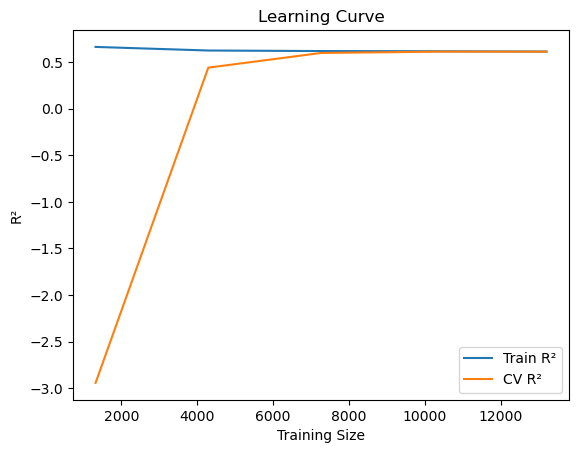

Train R² mean: 0.612657679351486 | CV R² mean: 0.6114845090142159


In [14]:
train_sizes, train_scores, test_scores = learning_curve(
    Ridge(alpha=1), X_train_scaled, y_train, cv=5, scoring="r2", train_sizes=np.linspace(0.1, 1, 5)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train R²")
plt.plot(train_sizes, test_mean, label="CV R²")
plt.xlabel("Training Size")
plt.ylabel("R²")
plt.title("Learning Curve")
plt.legend()
plt.show()

print("Train R² mean:", train_mean[-1], "| CV R² mean:", test_mean[-1])

## Step 14: Final Summary

In [15]:
final_model = Ridge(alpha=1)
final_model.fit(X_train_scaled, y_train)
y_final = final_model.predict(X_test_scaled)

print("Final MAE:", mean_absolute_error(y_test, y_final))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_final)))
print("Final R²:", r2_score(y_test, y_final))

print("Top 3 Drivers:")
print(coef_df.head(3))

Final MAE: 0.5331931195789734
Final RMSE: 0.745556744281478
Final R²: 0.5758157428913682
Top 3 Drivers:
     Feature  Coefficient
6   latitude    -0.896929
7  longitude    -0.869842
0     medinc     0.854383
